# Intelligent Systems - Individual Project Assessment
I aim to split the code into 3 sections:
1. Generating and analysing the datset
2. Developing my classification model
3. Training my model

In [47]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import v2
from torch.nn import functional as F
from scipy import io as sio

# torch.manual_seed(30)
# torch.cuda.empty_cache()

In [48]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
Tesla T4


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datase

In [49]:
# We perform random transformations to better generalise the training dataset
train_transform = transforms.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    # These are the values I have calculated
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Downloading and splitting the dataset

In [50]:
# I will download the data from PyTorch's website and use the appropriate data loader
train_dataset = datasets.Flowers102(
    root='',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)

valid_dataset = datasets.Flowers102(
    root='',
    split="val",
    download=True,
    transform=valid_transform,
    # target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = datasets.Flowers102(
    root='',
    split="test",
    download=True,
    transform=test_transform
)

# Get the targets and ids
image_labels = sio.loadmat("flowers-102/imagelabels")
setids = sio.loadmat("flowers-102/setid")
print(setids['trnid'])

[[6765 6755 6768 ... 8026 8036 8041]]


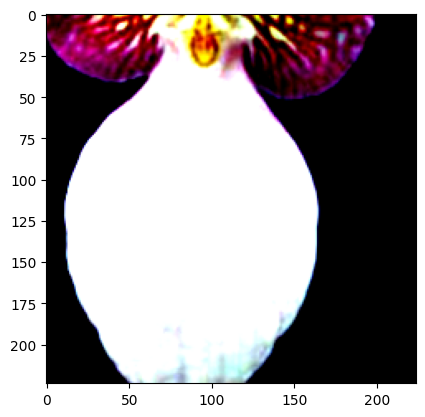

In [51]:
image, label = train_dataset[12]
plt.imshow(image.cpu().permute(1,2,0))

Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 0
Device tensor is stored on: cuda:0


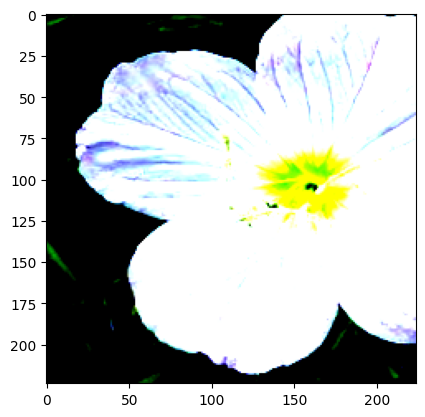

In [52]:
# look at the first training sample
image, label = train_dataset[1]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.cpu().permute(1, 2, 0))

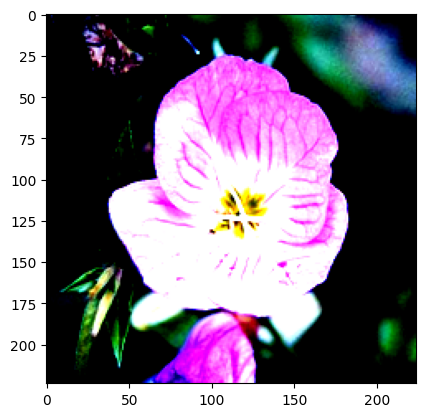

In [53]:
image2, label = test_dataset[0]
plt.imshow(image2.cpu().permute(1, 2, 0))

## Model

### Model 6

In [54]:
class MyNN6(nn.Module):
    def __init__(self):
        super().__init__()
        # First, try to get the bigger picture (max pooling and larger filter)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )

        # Gradually build up features
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256)
        )
        # self.layer5 = nn.Sequential(
        #     nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        #     nn.LeakyReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=1),
        #     nn.BatchNorm2d(512)
        # )

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Sequential(
            nn.Linear(256*14*14, 8192),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc4 = nn.Linear(256, 102)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.layer5(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

### Model 7

In [55]:
class MyNN7(nn.Module):
    def __init__(self):
        super().__init__()
        # First, try to get the bigger picture (max pooling and larger filter)
        # output of sequence is 56x56x64
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256)
        )

        # Gradually build up features
        # output is 28x28x128
        self.layer2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )
        # output is 14x14x256
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        # output is 7x7x32
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(32*7*7, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
        )
        self.fc3 = nn.Linear(512, 102)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

### Model 8
Here, I am going to try reduce the number of pooling layers, as information may be lost when using too many

In [56]:
class MyNN8(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*14*14, 2048),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, 1024)
        )
        self.fc3 = nn.Linear(1024, 102)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

### Model 9

In [57]:
class ResidualBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(planes),
        )
        self.relu = nn.ReLU()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.layer1(x)
        out = self.layer2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [58]:
class MyNN9(nn.Module):
    def __init__(self):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ) # output, 64 x 56 x 56

        self.layer1 = self.layer(ResidualBlock, 64, 3)
        self.layer2 = self.layer(ResidualBlock, 128, 4, stride=2)
        self.layer3 = self.layer(ResidualBlock, 256, 6, stride=2)
        self.layer4 = self.layer(ResidualBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 102)
        )

    def layer(self, block, planes, blocks, stride=1):
        downsample = None

        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        return x

### Model 10

In [59]:
class MyNN10(nn.Module):
    def __init__(self):
        super(MyNN10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 102),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Choosing the Model

In [60]:
model = MyNN8()
model.to(device)

MyNN8(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer5): Sequential(
    (0): 

## Training

### Loss Function

In [61]:
# Targets don't have to be one-hot encoded
# Model output (criterion input) is expected to contain un-normalised inputs
criterion = nn.CrossEntropyLoss()

### Optimiser

In [62]:
# Momentum pushes the optimiser towards the strongest gradient over multiple steps.
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimiser = optim.Adam(model.parameters(), lr=0.003)

### Dataloaders

In [63]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

In [64]:
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=True, num_workers=2)

### Train Function

In [65]:

def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimiser.zero_grad(set_to_none=True)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimiser.step()

    correct = 0
    train_loss = 0.
    model.eval()
    with torch.no_grad():
        # Get the loss/accuracy of the training set
        for i, (inputs, labels) in enumerate(dataloader):
            # Move the data to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update the test loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data).float()
    train_loss /= size
    correct /= size
    return train_loss, correct

### Validation Function

In [66]:
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # Update the val loss and accuracy
            val_loss += loss_fn(pred, y).item()
            _, preds = torch.max(pred, 1)
            correct += torch.sum(preds == y.data).float()
    val_loss /= size
    correct /= size
    print(f"Validation Set, Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return correct, val_loss

In [67]:
class EarlyStopping:
    def __init__(self, patience=1, min_delta=0.0):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.min_delta = min_delta  # the minimum change to be counted as improvement
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf

    # return True when validation loss is not decreased by the `min_delta` for `patience` times
    def early_stop_check(self, validation_loss):
        if ((validation_loss+self.min_delta) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased at least by min_delta
        elif ((validation_loss+self.min_delta) > self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased by the min_delta
            if self.counter >= self.patience:
                return True
        return False

### Full training of model

In [68]:

# def train_val_model(model, train_loader, valid_loader, criterion, optimiser, epochs, PATH):
#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []
#     best_acc = 0.

#     # For enhanced GPU performance
#     if device == 'cuda':
#         torch.backends.cudnn.benchmark = True

#     # early_stopper = EarlyStopping(patience=15, min_delta=0.01)

    print("[INFO] Training starting...")
    start_time = time.time()
#     for e in range(epochs):
#         print(f"Epoch {e+1}\n-------------------------------")

#         train_loss, train_accuracy = train(train_loader, model, criterion, optimiser)
#         print(f"Training Set: Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {train_loss:>8f}")
#         train_losses.append(train_loss)
#         train_accuracies.append(train_accuracy)

#         val_acc, val_loss = validate(valid_loader, model, criterion)
#         val_accuracies.append(val_acc)
#         val_losses.append(val_loss)

#         # if early_stopper.early_stop_check(val_loss):
#         #     break
#         if val_acc > best_acc:
#             best_acc = val_acc
#             torch.save(model.state_dict(), PATH)

#     finish_time = time.time()
#     print("[INFO] Testing and training completed.")
#     print(f"Elapsed time: {math.floor((finish_time-start_time)/60)}:{math.floor((finish_time-start_time)%60)}")
#     return train_losses, train_accuracies, val_losses, val_accuracies
def train_model(model, criterion, optimizer, train_loader, valid_loader, path, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        valid_loss = 0.0
        valid_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)
                valid_corrects += torch.sum(preds == labels.data)

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_acc = valid_corrects / len(valid_loader.dataset)
        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), path)
        val_accuracies.append(valid_acc)
        val_losses.append(valid_loss)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [69]:
epochs = 20
PATH = 'models/model8.pth'

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, criterion, optimiser, train_loader, valid_loader, PATH, epochs)

RuntimeError: Expected a 'cuda' device type for generator but found 'cpu'

### Visualisation

In [ ]:
# Visualise the losses
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Visualise the accuracy
plt.plot(train_accuracies.copy(), label='Training')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing

In [ ]:
# Test on test dataset
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2, generator=torch.Generator(device=device))

In [ ]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(test_loader):
            X = data[0].to(device)
            y = data[1].to(device)

            predicted = model(X)

            # Check each image's prediction
            acc += (predicted.argmax(1) == y).type(torch.float).sum().item()
    model.train()
    return acc/len(test_loader.dataset)

In [ ]:
test_model = MyNN10().to(device)
test_model.load_state_dict(torch.load(PATH))
test_acc = test(test_model, test_loader)

In [ ]:
print(f"Test Accuracy: {test_acc*100:.2f}%")